Your Name: Dylan Rodrigues

Your ID Number: 24121479

# Etivity 3 - Task 1-2: Use Tensorflow and Keras to build a CNN model for dog vs. cat classification using transfer learning based on the VGG16 model.

Until now, you've built your own simple CNN model using TensorFlow Keras libraries. In this notebook you will carry out transfer learning by modifying the VGG16 model [1] that has came from 2014 ImageNet [2] competition.

By the end of this notebook, you'll be able to: 

* Load a pre-trained VGG16 model using the TensorFlow/Keras framework.
* Replace the last layer from 1000 nodes down to 2 nodes for dog vs. cat classification.
* Modify the trainable paramters to false except for the last lasyer.
* Fit the model to the training set.
* Analyse the model perfromance.
* Results analysis.
* Store and Load your model architectures.


### Important Note on Submission 

There are code exercises to complete in this task. Use the notes provided to help you build understanding. Insert your code entries into the cell areas marked with the 'enter code here' text as below, so that grading can easily be assessed.

\### **ENTER CODE HERE**

Please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.


Let's get started!

## Table of Contents
- [1- Packages and Dataset](#1)
    - [1.1 - Prepare the dataset](#1-1)
- [2 - Tensorflow/Keras download and modify the VGG16 CNN model](#2)
    - [2.1 - Import the VGG16 model](#2-1)
    - [2.2 - Modify the model](#2-2)
- [3 - Compile and train the model](#3)
- [4 - Analyse model performance](#4)
- [5 - Results analysis](#5)
- [6 - Test your own image (optional)](#6)
- [7 - Save the model and weights](#7)
- [8 - Visualise filters (optional)](#8)
- [9 - Visualise feature maps (optional)](#9)

<a name='1'></a>
## 1- Packages and Dataset

In [1]:
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import math
import itertools
import os
import shutil
import random
import glob
import warnings
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

from scipy import ndimage
from PIL import Image
from keras_cnn_app_utils import *

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

# Measure time taken
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

**Use this code cell only if you have a GPU**

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


### 1.1 Prepare the dataset

In [3]:
# Organize data into train, valid, test dirs
os.chdir('dataset')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
# Only use a small subset of the entire 25000 images available from the kaggle dataset
# 1000 images for training set
# 150  images for valid set
# 100  images for test set
    for i in random.sample(glob.glob('cat*'), 500):
        shutil.move(i, 'train/cat')      
    for i in random.sample(glob.glob('dog*'), 500):
        shutil.move(i, 'train/dog')
    for i in random.sample(glob.glob('cat*'), 75):
        shutil.move(i, 'valid/cat')        
    for i in random.sample(glob.glob('dog*'), 75):
        shutil.move(i, 'valid/dog')
    for i in random.sample(glob.glob('cat*'), 50):
        shutil.move(i, 'test/cat')      
    for i in random.sample(glob.glob('dog*'), 50):
        shutil.move(i, 'test/dog')

os.chdir('..')

In [4]:
train_path = 'dataset/train'
valid_path = 'dataset/valid'
test_path = 'dataset/test'

**Preprocess images similar to what the famous vgg16 model does**

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
assert train_batches.n == 1000
assert valid_batches.n == 150
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [7]:
# Grab the images and labels from the training batch (10)
imgs, labels = next(train_batches)

In [8]:
# This function plots images in the form of a grid with 1 row and 10 colummns (from tensorflow site)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-104.68..140.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data 

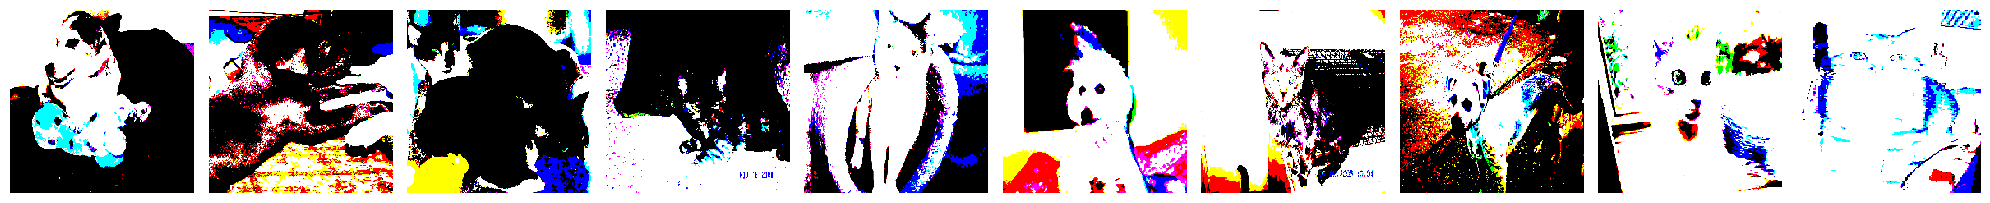

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [9]:
plotImages(imgs)
print(labels)

<a name='2'></a>
## 2 - Download and modify the VGG16 CNN model

<a name='2-1'></a>
### 2.1 Import the VGG16 CNN model and report on the model structure

1. Import the VGG16 model from Keras. Note, an internet connection is needed to download this model.
2. Report on the model.summary().
3. Report on the model type.
4. Check how many layers in this model.

In [10]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [11]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
type(vgg16_model)

keras.engine.functional.Functional

In [13]:
len(vgg16_model.layers)

23

<a name='2-2'></a>
### 2.2 Modify the VGG16 CNN model for dog vs. cat classification and report on the model structure

This is a functional API Keras model for ImageNet classification. We only need 2 outputs for our dog vs. cat classification and so we will build a new model - Sequential using the same layers as in VGG16 upto the last layer.


1. (a) Create a new Sequential model thats uses the VGG16 model upto to the last layer and (b) show the model structure.
2. (a) Make all these layers not trainable (b) then add a new final layer with 2 units using a softmax activation and (c) Show the new model structure.

In [14]:
# Load the VGG16 model without the top classification layer
def create_new_model_from_existing_model(base_model):
    model = Sequential()
    for layer in base_model.layers[:-1]:
        model.add(layer)
    return model
    
model = create_new_model_from_existing_model(vgg16_model)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [15]:
### ENTER CODE HERE 
for layer in model.layers:
    layer.trainable = False
# model.add(Flatten())  # Flattening the output from the convolutional layers
model.add(Dense(2, activation="softmax"))  # Binary classification (dog vs. cat)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

<a name='3'></a>
## 3 - Train the VGG16 model for dog vs. cat classification

###  Compile the CNN model and train the network

1. Use **model.compile()** to compile the CNN model using Adam optimization and a learning_rate = 0.0001. Also specify categorical_crossentropy as the loss function and report on the accuracy metric.


2. Use **history=model.fit()** with inputs 'x=train_batches' and 'steps_per_epoch=len(train_batches)'. Also set 'validation_data=valid_batches' as input, so that you can investigate the valid set loss/accuracy figure. This will be useful in determining the performance of this model. Use 5 epochs with 100 minibatchs in each epoch to train the network.

In [16]:

# Compile the model using Adam optimizer and categorical crossentropy loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [17]:
# Note Generator inherently contains the y label values in train_batches, so there is no need to pass y data
history = model.fit(
    train_batches,  # Training data generator
    steps_per_epoch=len(train_batches),  # Number of steps per epoch
    validation_data=valid_batches,  # Validation data generator
    validation_steps=len(valid_batches),  # Number of validation steps
    epochs=5,  # Number of epochs
)
# If you want to use the GPU to train the model quicker - insert this line before the training - "with tf.device('/GPU:0'):"

Epoch 1/5
100/100 [==============================] - 14s 81ms/step - loss: 0.3203 - accuracy: 0.8520 - val_loss: 0.1036 - val_accuracy: 0.9733
Epoch 2/5
100/100 [==============================] - 3s 30ms/step - loss: 0.0961 - accuracy: 0.9610 - val_loss: 0.0850 - val_accuracy: 0.9667
Epoch 3/5
100/100 [==============================] - 3s 29ms/step - loss: 0.0660 - accuracy: 0.9780 - val_loss: 0.0756 - val_accuracy: 0.9800
Epoch 4/5
100/100 [==============================] - 3s 29ms/step - loss: 0.0497 - accuracy: 0.9870 - val_loss: 0.0751 - val_accuracy: 0.9800
Epoch 5/5
100/100 [==============================] - 3s 29ms/step - loss: 0.0395 - accuracy: 0.9880 - val_loss: 0.0798 - val_accuracy: 0.9733


<a name='4'></a>
## 4 - Analyse model performance: Loss, predictions and confusion matrix

<a name='4-1'></a>
### 4.1 **Plot** the model loss and accuracy metrics in the code cell below

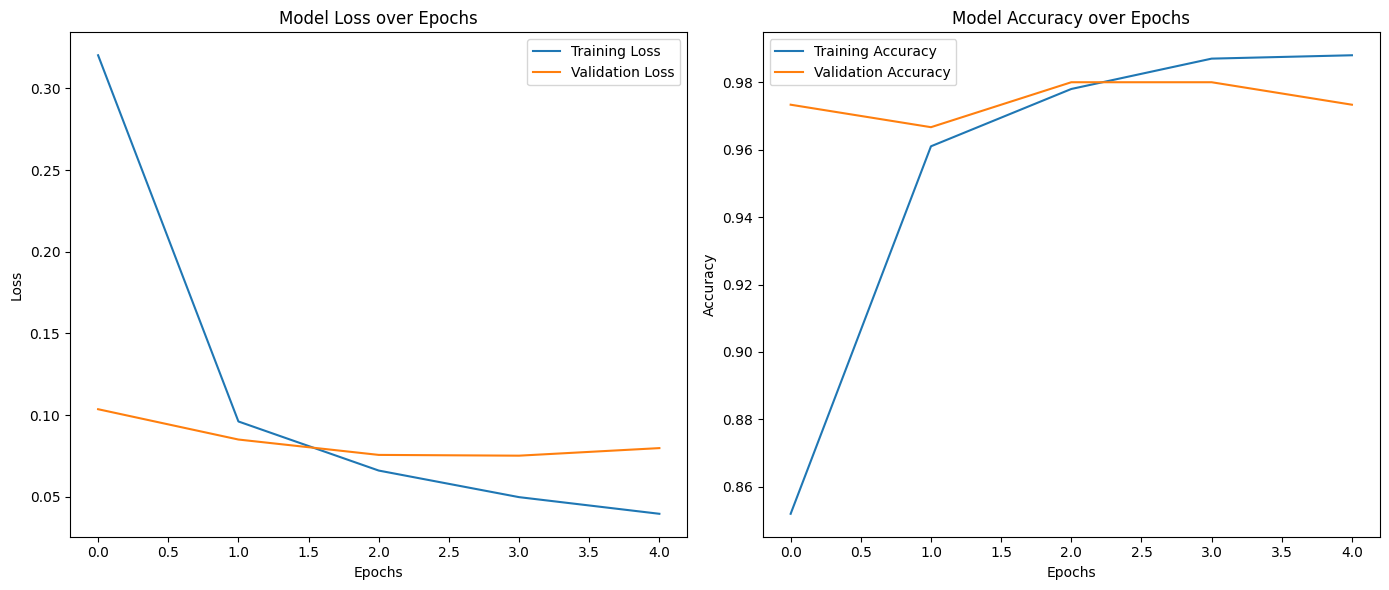

In [18]:
### ENTER CODE HERE

import matplotlib.pyplot as plt

# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot training and validation loss on the left subplot
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Model Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training and validation accuracy on the right subplot
axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Model Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

**What** do these plots reveal about the fine-tuned model performance?
**Enter your observations in the markdown cell**

### <span style='color: red;'>ENTER COMMENTS HERE.</span> ###

The plots indicate that the fine-tuned VGG16 model exhibits high accuracy but shows signs of overfitting. The training loss decreases consistently, while the validation loss initially decreases but then slightly increases, suggesting the model is memorizing training data rather than generalizing well. Similarly, the training accuracy approaches 99%, while validation accuracy stagnates around 97% before showing a minor decline. This aligns with findings in deep learning research that excessive fine-tuning of pre-trained models with small datasets can lead to overfitting, as feature extraction layers already capture essential representations (Goodfellow et al., 2016) [1]. Regularization techniques such as dropout or data augmentation could help improve generalization.  

**References:**  
[1] I. Goodfellow, Y. Bengio, and A. Courville, *Deep Learning*. MIT Press, 2016.

<a name='4-2'></a>
### 4.2 Generate the predictions and plot the confusion matrix

1. Analyse the predictions by using the **model.predict()** function call on the test_batches dataset. Note that the output of the CNN model is a probability (float) value ranging from 0.0 to 1.0. Recall we have 2 output nodes for a separate 'cat' and 'dog' classification, so if the probability of output 1 (cat feature) is greater than 0.5, than this is more likely to be a 'cat' classification. Whereas, if the probability of output 2 (dog feature) is greater than 0.5, than the model is predicting the image is a 'dog' classification. You might find it useful to round the predictions to a '0' for a cat or '1' for a dog' into a 1-D array for the confusion matrix setup.

In [19]:
# 1. Calculate the predictions on the test_batches set from the trained model using model.predict()
predictions = model.predict(test_batches, steps=len(test_batches), verbose=1)

# 2. Round the prediction probabilities to a value 0 (cat) or 1 (dog) into a 1-D array
predicted_classes = np.argmax(predictions, axis=1)

10/10 [==============================] - 1s 88ms/step


In [20]:
true_classes = test_batches.classes

In [22]:
print("predictions: ", predictions)
print("predicted classes: ", predicted_classes)
print("true classes: ", true_classes)

predictions:  [[9.99513030e-01 4.87011508e-04]
 [9.89770651e-01 1.02293696e-02]
 [9.97612000e-01 2.38803867e-03]
 [9.99740303e-01 2.59656605e-04]
 [9.99937057e-01 6.28920170e-05]
 [9.89576459e-01 1.04235513e-02]
 [9.95742023e-01 4.25791740e-03]
 [9.99852657e-01 1.47281695e-04]
 [9.99631524e-01 3.68451583e-04]
 [9.99490619e-01 5.09338570e-04]
 [9.99987364e-01 1.26947534e-05]
 [9.99945998e-01 5.40086112e-05]
 [9.97051001e-01 2.94902292e-03]
 [9.11328971e-01 8.86710137e-02]
 [6.18579388e-01 3.81420672e-01]
 [9.79199588e-01 2.08004098e-02]
 [9.99927163e-01 7.27881561e-05]
 [9.88201320e-01 1.17986510e-02]
 [9.84148681e-01 1.58512890e-02]
 [9.81334805e-01 1.86652038e-02]
 [6.48935735e-01 3.51064295e-01]
 [6.98381960e-01 3.01618069e-01]
 [9.99561846e-01 4.38194897e-04]
 [9.99201953e-01 7.98093562e-04]
 [9.99413252e-01 5.86767390e-04]
 [9.95642066e-01 4.35790885e-03]
 [9.99961138e-01 3.89060588e-05]
 [8.03682506e-01 1.96317494e-01]
 [9.99218345e-01 7.81618932e-04]
 [9.99887824e-01 1.12207781e-

2. Plot the performance of the predictions usign a **confusion matrix**. Use the sklearn.metrics confusion_matrix() command with the test_batches correct predictions and predictions from the trained model as inputs. Label the plot correctly and analyze the result - what does this plot inform you about the level of model performance?
**Note**: You can use the plot_confusion_matrix() routine in the keras_cnn_app_utils.py file.

Confusion matrix, without normalization
[[48  2]
 [ 2 48]]


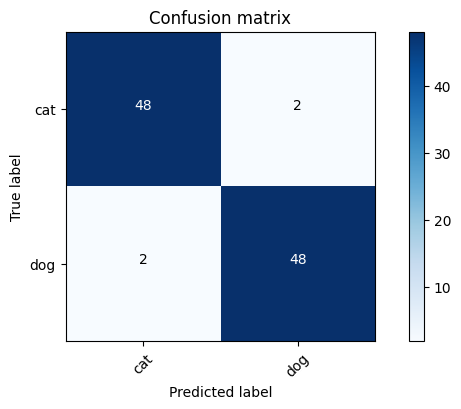

In [24]:
# 1. Use the confusion matrix() from sklearn.metrics to get the cm values
# 2. Plot the performance of the predictions using the plot_confusion_matrix() routine
from sklearn.metrics import confusion_matrix

def compute_confusion_matrix(true_labels, predicted_labels):
    """
    Compute the confusion matrix for model predictions.

    Args:
        true_labels (np.ndarray): True class labels from the test dataset.
        predicted_labels (np.ndarray): Predicted class labels from the model.

    Returns:
        np.ndarray: Computed confusion matrix.
    """
    return confusion_matrix(true_labels, predicted_labels)

# Extract true labels from test_batches
true_labels = test_batches.classes  # Assuming test_batches is an ImageDataGenerator
# Compute confusion matrix
conf_matrix = compute_confusion_matrix(true_labels, predicted_classes)
# Plot confusion matrix
class_names = list(test_batches.class_indices.keys())  # Get class names
plot_confusion_matrix(conf_matrix, class_names)

**What story does the confusion matrix tell** - Place your commentary on the confusion matrix in the markdown cell below.

### <span style='color: red;'>ENTER COMMENTS HERE.</span> ###


The confusion matrix indicates that the fine-tuned CNN model demonstrates strong classification performance with high accuracy. Out of 50 cat images, 48 were correctly classified as cats, while only 2 were misclassified as dogs. Similarly, out of 50 dog images, 48 were accurately labeled as dogs, with only 2 misclassified as cats. This suggests a well-generalized model with minimal misclassification errors. The low number of false positives and false negatives signifies that the model has effectively learned relevant features for distinguishing between cats and dogs. However, a deeper analysis, including precision, recall, and F1-score, could provide further insight into class-specific performance [1]. 

**References:**  
[1] I. Goodfellow, Y. Bengio, and A. Courville, *Deep Learning*, Cambridge, MA, USA: MIT Press, 2016.

<a name='5'></a>
##  5 - Results Analysis

First, take a look at some of the images the vgg16 CNN model labeled incorrectly. This will show a few mislabeled images form the original rgb test dataset. 

In [25]:
def load_testset():
    # load the original rgb images into a test set
    size = 224
    X_test = []
    Y_test = []
    
    testpath = "./dataset/test/cat"
    file = os.listdir(testpath)
    files = gb.glob(pathname = str( testpath + '/*.jpg'))
    
    for file in files: 
        image = cv2.imread(file)
        image_array = cv2.resize(image , (size,size))
        X_test.append(list(image_array))
        file=file.split('\\')[-1]
        sep=file.split('.')[0]
        if(sep == 'cat'):
            Y_test.append(0)
        else:
            Y_test.append(1)
            
    testpath = "./dataset/test/dog"
    file = os.listdir(testpath)
    files = gb.glob(pathname = str( testpath + '/*.jpg'))
    
    for file in files: 
        image = cv2.imread(file)
        image_array = cv2.resize(image , (size,size))
        X_test.append(list(image_array))
        file=file.split('\\')[-1]
        sep=file.split('.')[0]
        if(sep == 'dog'):
            Y_test.append(1)
        else:
            Y_test.append(0)
     
    X_test = np.array(X_test);
    test_x = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],X_test.shape[3]);
    test_y = np.array(Y_test);
    classes = ['cat', 'dog'];
    
    return test_x, test_y, classes

In [26]:
# load the raw rgb image test set and reshape into a flattened rgb value - first reshape image samples to [224,224,3,100]
test_x, test_y, classes = load_testset()
test_x1 = test_x.reshape(test_x.shape[1],test_x.shape[2],test_x.shape[3],test_x.shape[0])
# flatten rgb values
test_x_flatten = test_x1.reshape(test_x1.shape[3],-1).T

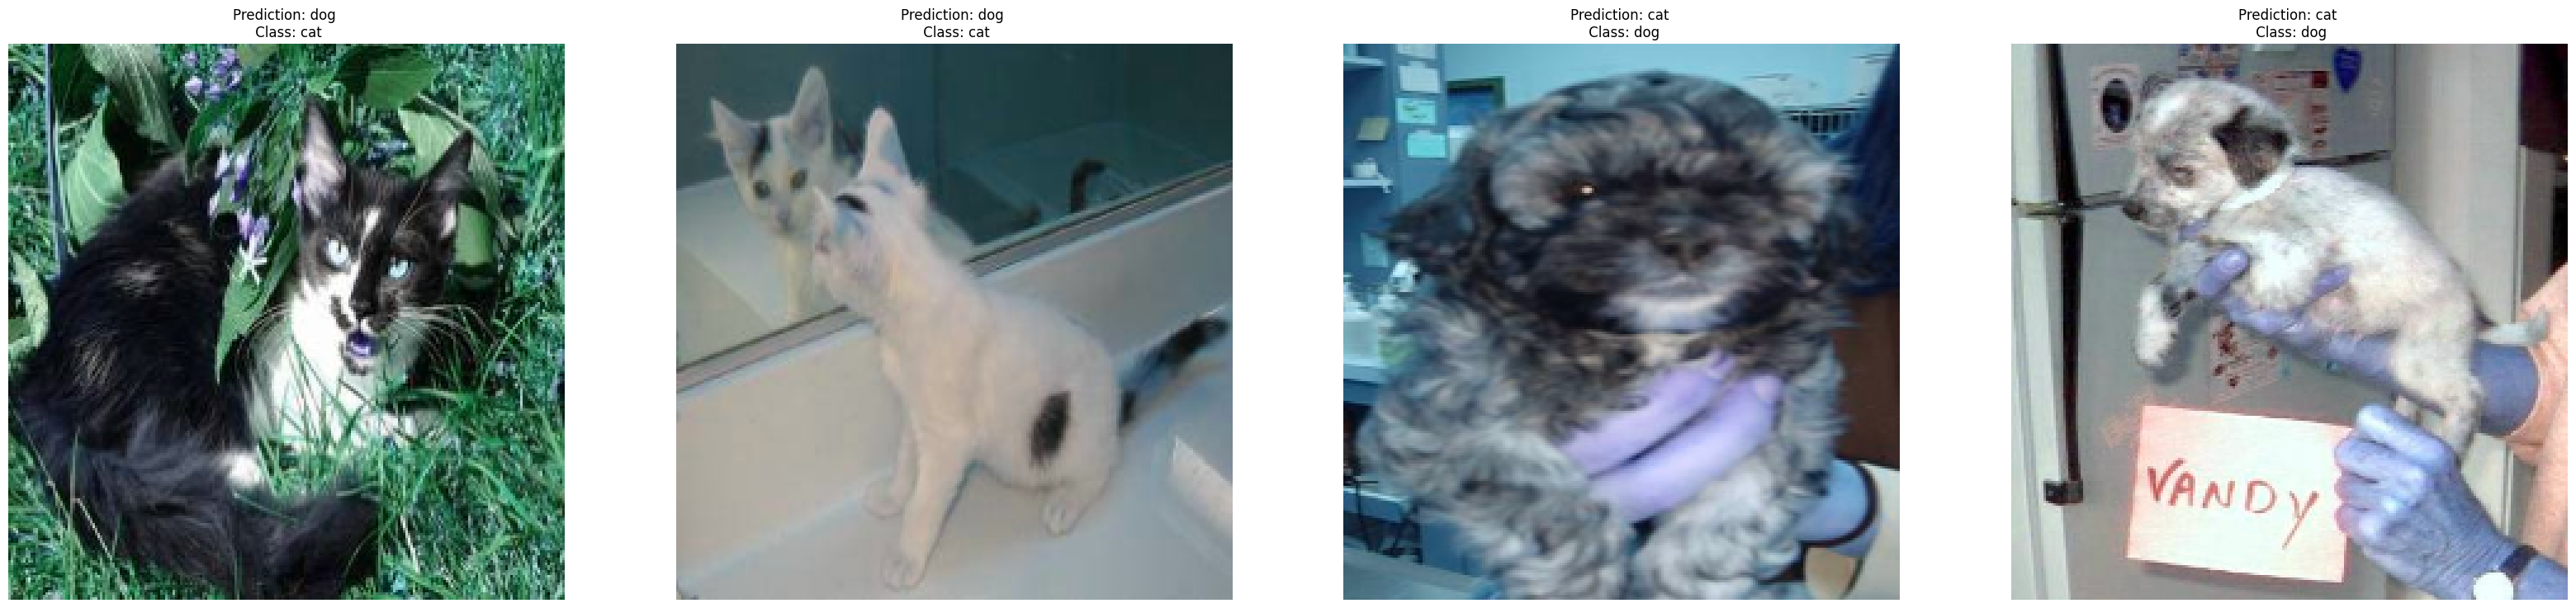

In [27]:
classes = ['cat','dog']
# use the predictions from the processed test_batches image dataset
print_mislabeled_images(classes, test_x_flatten, test_y, np.argmax(predictions, axis=-1))
plt.show()

**In the markdown below, list some reasons why these images do poorly using this model employing Transfer learning?**

### <span style='color: red;'>ENTER COMMENTS HERE.</span> ###



There are several reasons why images may perform poorly when using transfer learning with a pre-trained model like VGG16. Firstly, the model might not generalize well to the new task due to domain differences between the source (ImageNet) and target (cats vs. dogs) datasets. The model's pre-trained weights are optimized for a wide variety of objects, and fine-tuning them on a small dataset may not be sufficient to capture task-specific features, leading to underfitting. Additionally, the small size of the dataset and potential class imbalance can also degrade performance, as the model might not have enough examples to learn the nuances of each class. Another factor could be overfitting, especially if the model’s layers aren't properly regularized or if training is conducted for too many epochs. Finally, the pre-processing steps may not match the specific requirements of the new dataset, affecting how well the model adapts to the new images.

Reference:
Ian Goodfellow, Yoshua Bengio, and Aaron Courville, *Deep Learning*, MIT Press, 2016.

<a name='6'></a>
## 6 - Test with your own image (optional exercise) ##

From this point, if you so choose, you can use your own image to test  the output of your model. To do that follow these steps:

1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your home directory.
2. Add your image to this Jupyter Notebook's directory, in the "images" folder
3. Change your image's name in the following code
4. Run the code and check if the algorithm is right (1 = dog, 0 = cat (non-dog))!

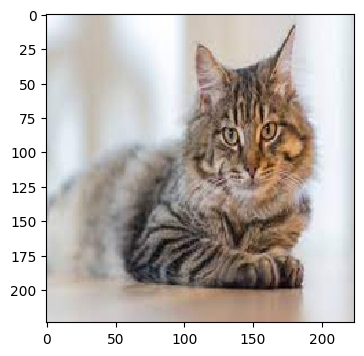

y = 0, your Keras VGG16 model predicts a "cat" picture.


In [28]:
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
my_image = "my_image_cat.jpg" # change this to the name of your image file 
num_px = 224
fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
plt.show()

image = image.reshape((1,num_px,num_px,3))

my_predicted_image = model.predict(x=image,verbose=0)
my_prediction = np.argmax(my_predicted_image, axis=-1)
print ("y = " + str(np.squeeze(my_prediction)) + ", your Keras VGG16 model predicts a \"" + classes[int(np.squeeze(my_prediction))] +  "\" picture.")

<a name='7'></a>
##  7 - Save model

In [29]:
# Check first to see if files already exists
# If not, the model and weights is saved to the disk
# Note model already contains the weights, but showing how it can done seprately
import os.path
if os.path.isfile('models/cat_vs_dog_vgg16_model.h5') is False:
    model.save('models/cat_vs_dog_vgg16_model.h5')
    
if os.path.isfile('models/cat_vs_dog_vgg16.weights.h5') is False:
    model.save_weights('models/cat_vs_dog_vgg16.weights.h5')

**Congratulations**! You've made it to the end of the notebook for designing CNNs using the Tensorflow/Keras Framework. Here's a quick recap of everything you're now able to do: 

* Modifed the VGG16 CNN model for dog vs. cat classification
* Analyse CNN model performance
* Looked at misclassified images
* Save your model

Great work!

<a name='8'></a>
## 8 - Visualise filters (optional)

Source: https://nthu-datalab.github.io/ml/labs/11-2_Visualization_Style-Transfer/11-2_Visualization_Style-Transfer.html

Now we can visualise the weights of the convolution filters to help us understand what neural network have learned. In neural network terminology, the learned filters are simply weights, yet because of the specialised two-dimensional structure of the filters, the weight values have a spatial relationship to each other and plotting each filter as a two-dimensional image is meaningful (or could be).

We can access the block of filters and the block of bias values through layer.get_weight(). In VGG16, all convolitional layers use 3x3 filters.

In [30]:
# summarise filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


Let's look at every single individual filter in the first convolutional layer. We will see all 64 in the block and plot each of the three channels. It is worth to meantion that in the first convolutional layer, it has total 192 feature maps(64 filters * 3 channels). We can normalise their values to the range 0-1 to make them easy to visualise.

The dark squares indicate small or inhibitory weights and the light squares represent large or excitatory weights. Using this intuition, we can see that the filters on the first row detect a gradient from light in the top left to dark in the bottom right.

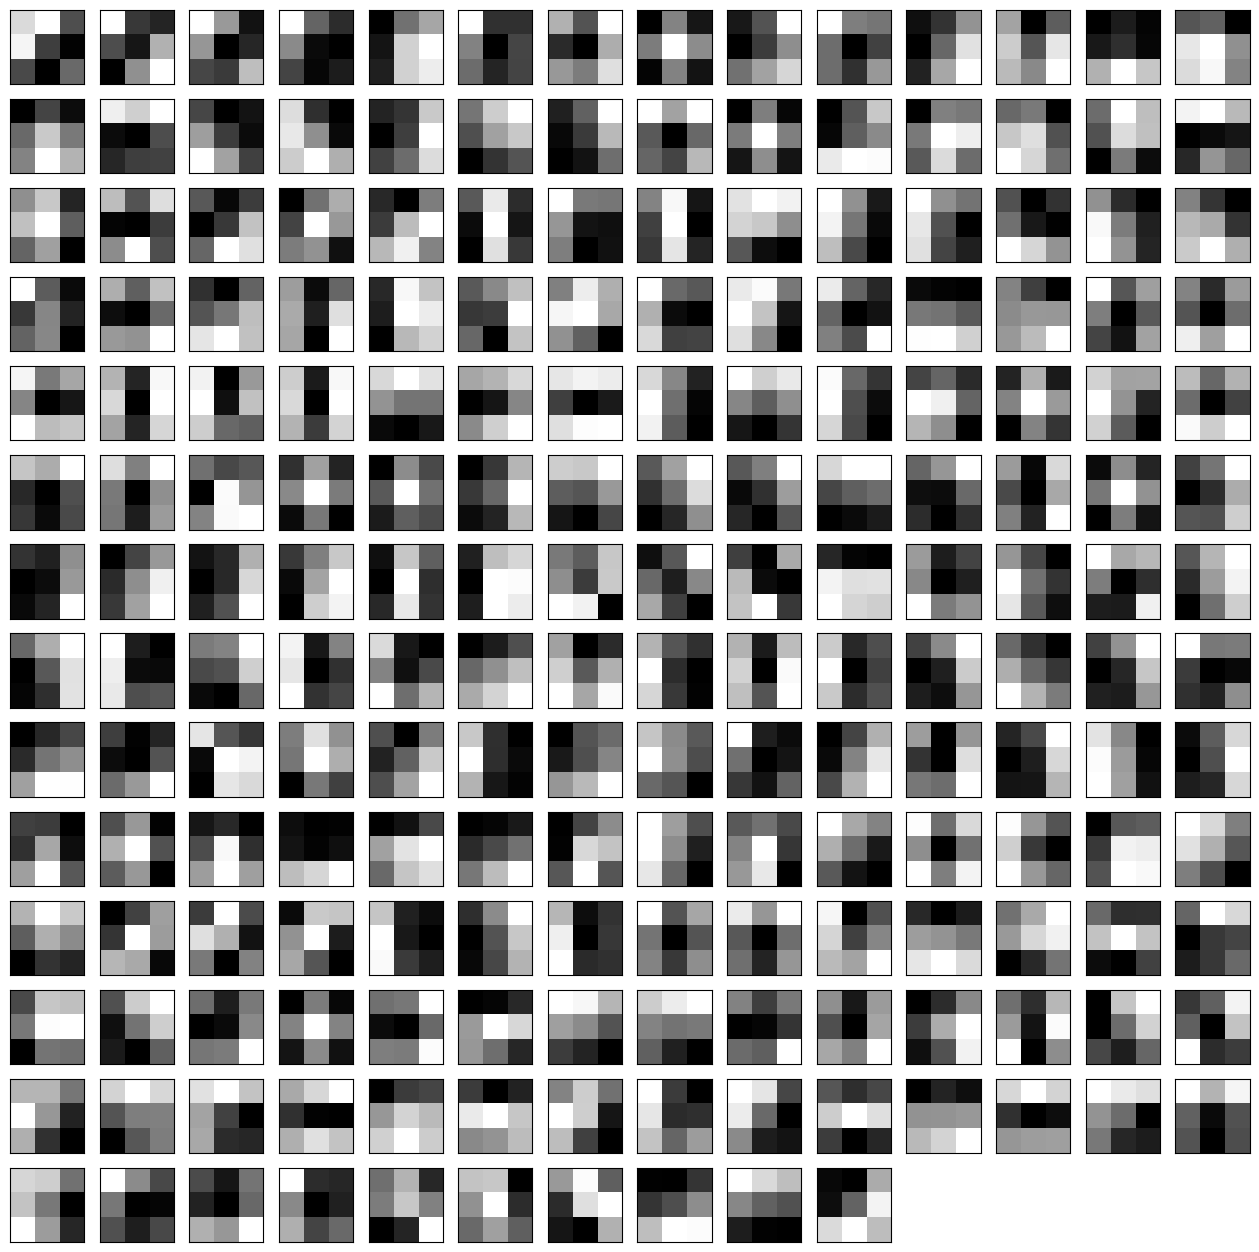

In [31]:
plt.figure(figsize=(16,16))

# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 64, 1

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(14, 14, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
        
# show the figure

<a name='9'></a>
## 9 - Visualise feature maps (optional)
The activation maps, called feature maps, capture the result of applying the filters to input, such as the input image or another feature map. The idea of visualising a feature map for a specific input image would be to understand what features of the input are detected or preserved in the feature maps. The expectation would be that the feature maps close to the input detect small or fine-grained detail, whereas feature maps close to the output of the model capture more general features.

We can see that the result of applying the filters in the first convolutional layer is a lot of versions of the input image with different features highlighted. For example, some highlight lines, other focus on the background or the foreground.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________
1/1 [==============================] - 0s 109ms/step


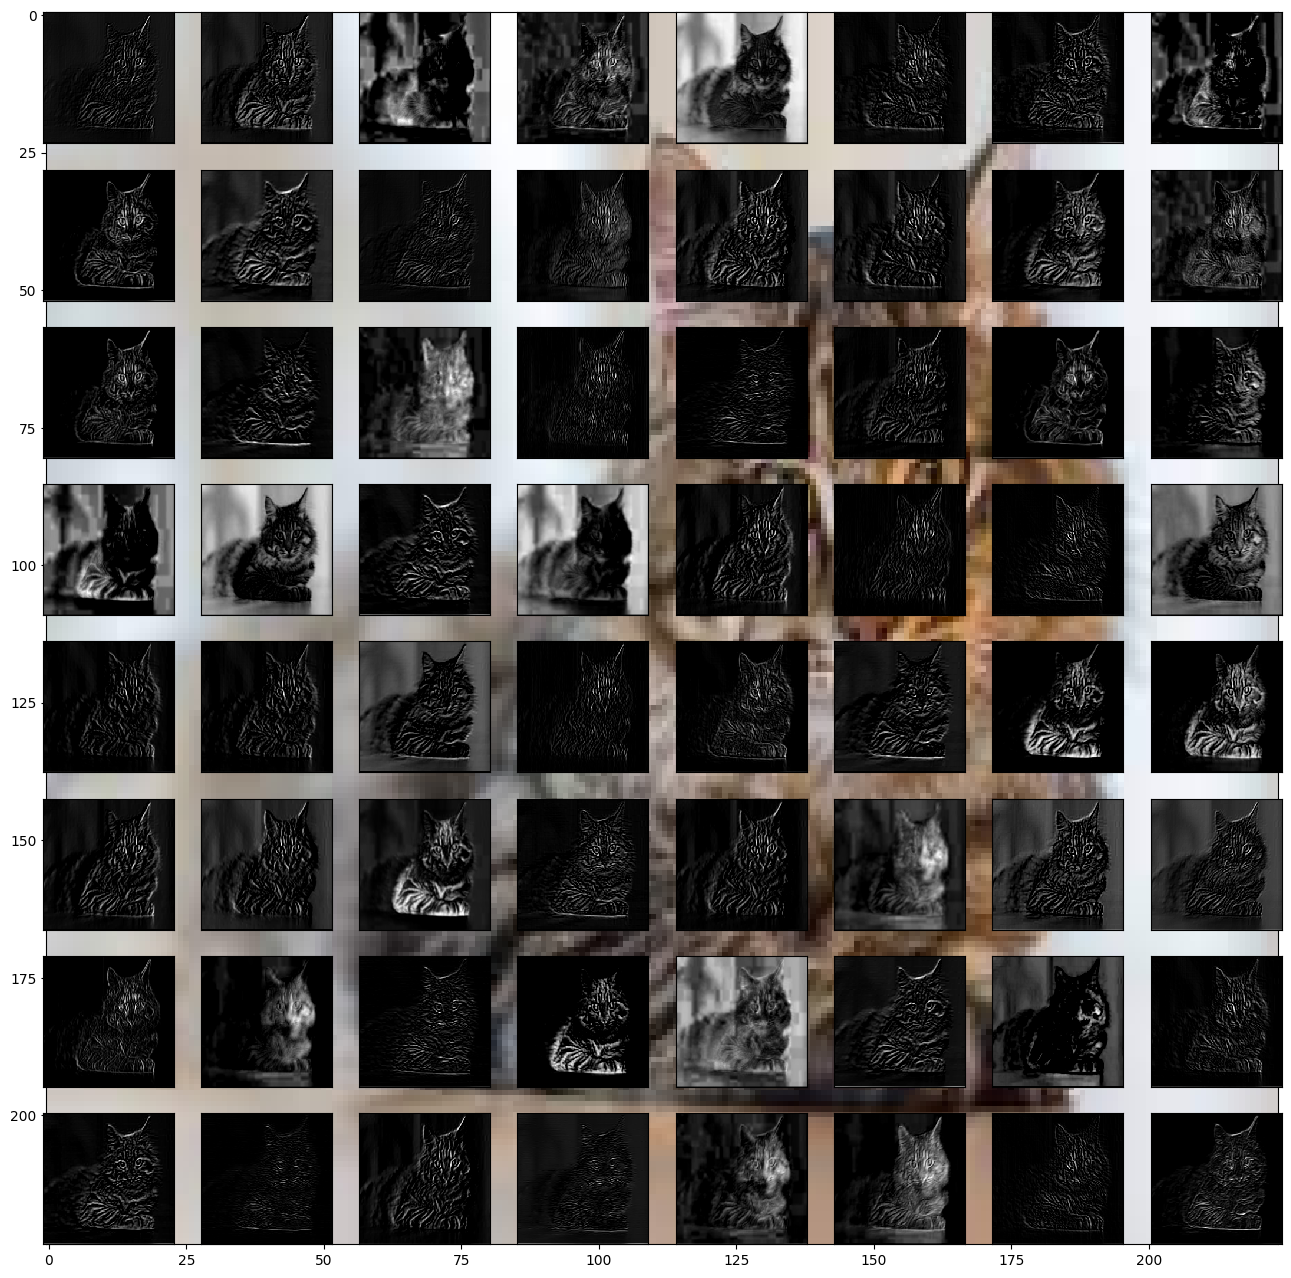

In [32]:
plt.figure(figsize=(16,16))

# redefine model to output right after the first hidden layer
model = tf.keras.Model(inputs=[model.input], outputs=model.layers[1].output)
model.summary()

# preprocess input
my_image = "my_image_cat.jpg" # change this to the name of your image file 
num_px = 224
fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)

content_image = image.reshape((1,num_px,num_px,3))
content_image = tf.keras.applications.vgg16.preprocess_input(content_image)
content_image = tf.image.resize(content_image, (224, 224))

# get feature map for first hidden layer
feature_maps = model.predict(content_image)

# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
        
# show the figure
pyplot.show()

Let's visualise the feature maps output from each block of the model. You might notice that the number of feature maps (e.g. depth or number of channels) in deeper layers is much more than 64, such as 256 or 512. Nevertheless, we can cap the number of feature maps visualised at 64 for consistency.

We can see that the feature maps closer to the input of the model capture a lot of fine detail in the image and that as we progress deeper into the model, the feature maps show less and less detail.

This pattern was to be expected, as the model abstracts the features from the image into more general concepts that can be used to make a classification. Although it is not clear from the final image that the model saw the cat, we generally lose the ability to interpret these deeper feature maps.

1/1 [==============================] - 0s 84ms/step
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 64), dtype=tf.float32, name=None), name='block1_conv2/Relu:0', description="created by layer 'block1_conv2'")


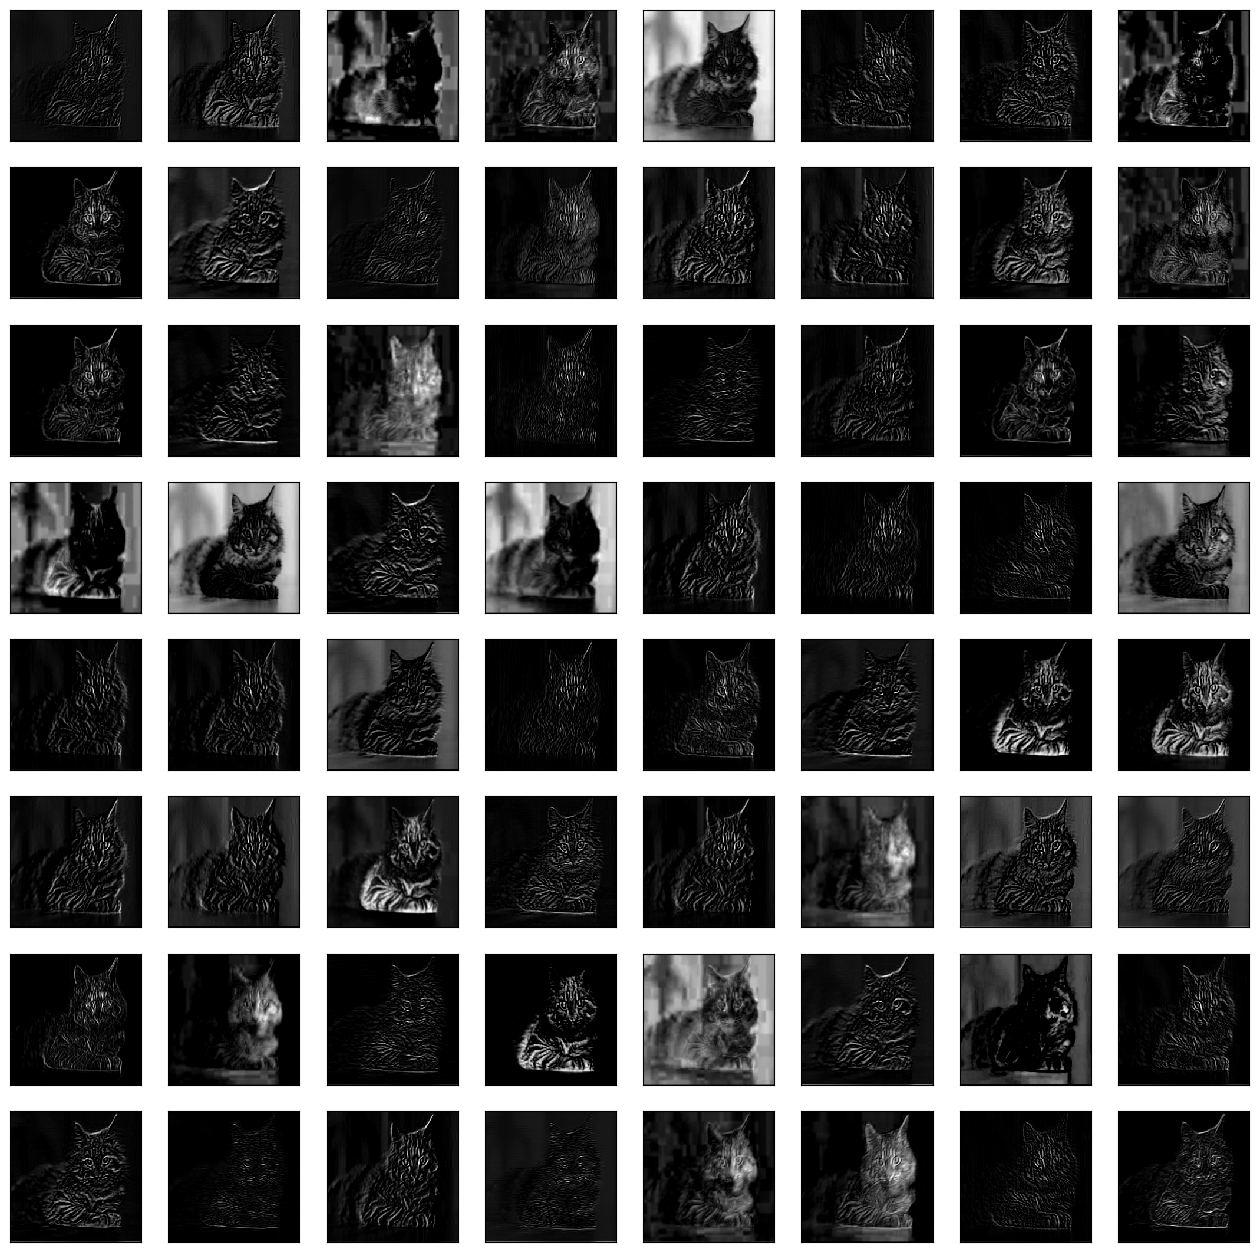

KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 128), dtype=tf.float32, name=None), name='block2_conv2/Relu:0', description="created by layer 'block2_conv2'")


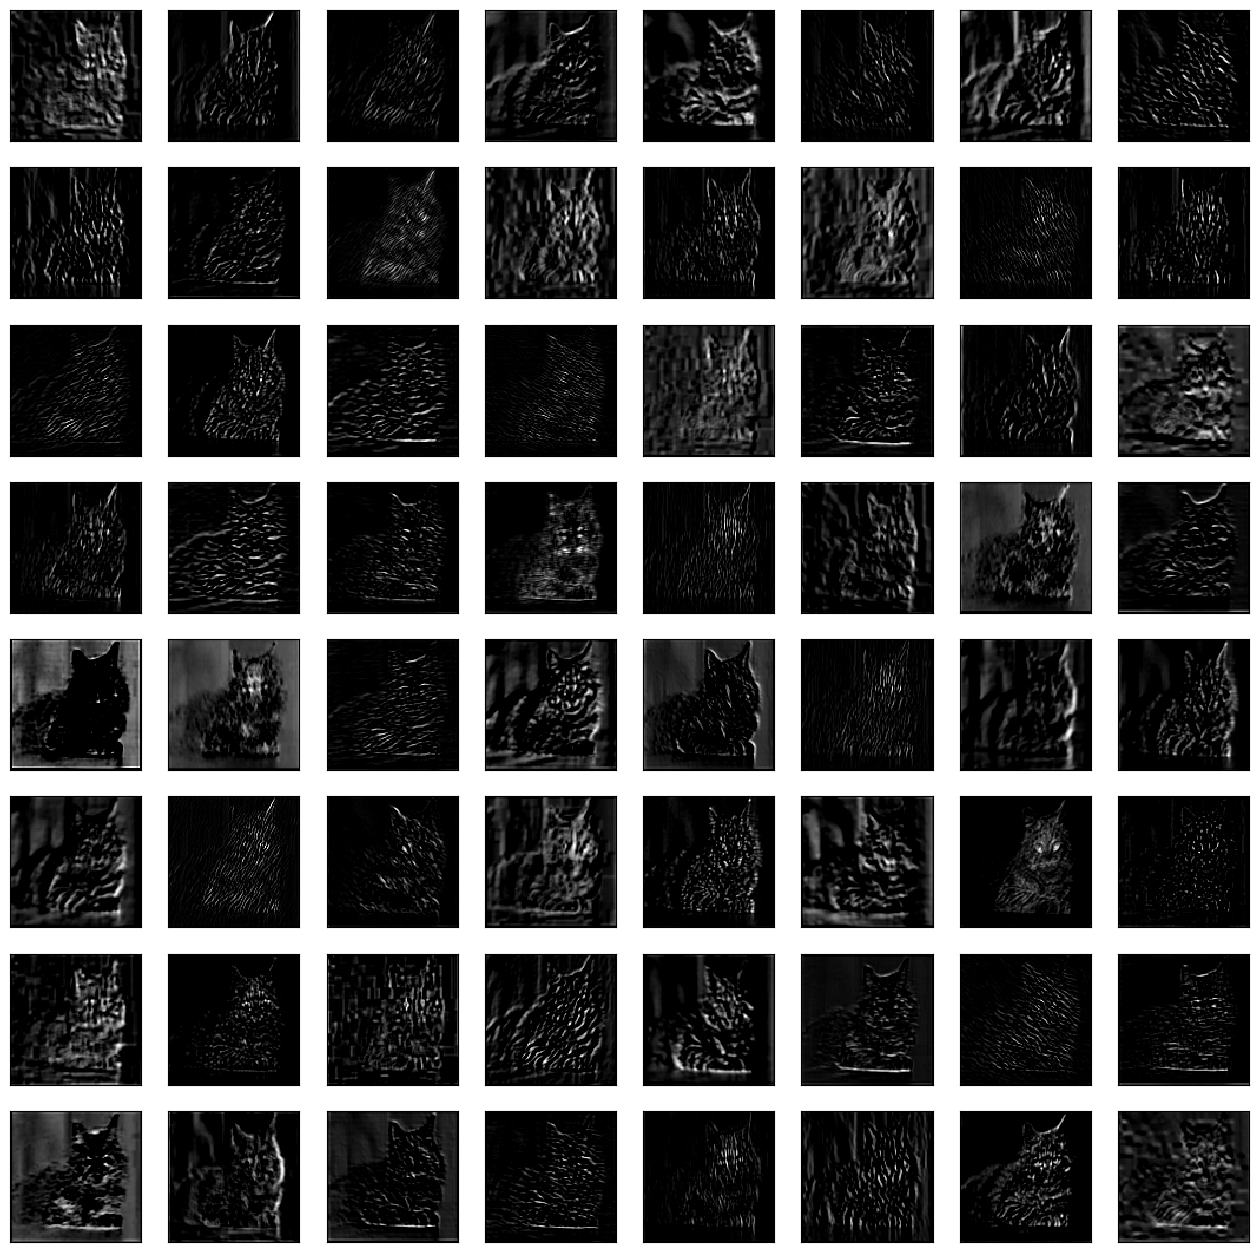

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 512), dtype=tf.float32, name=None), name='block4_conv1/Relu:0', description="created by layer 'block4_conv1'")


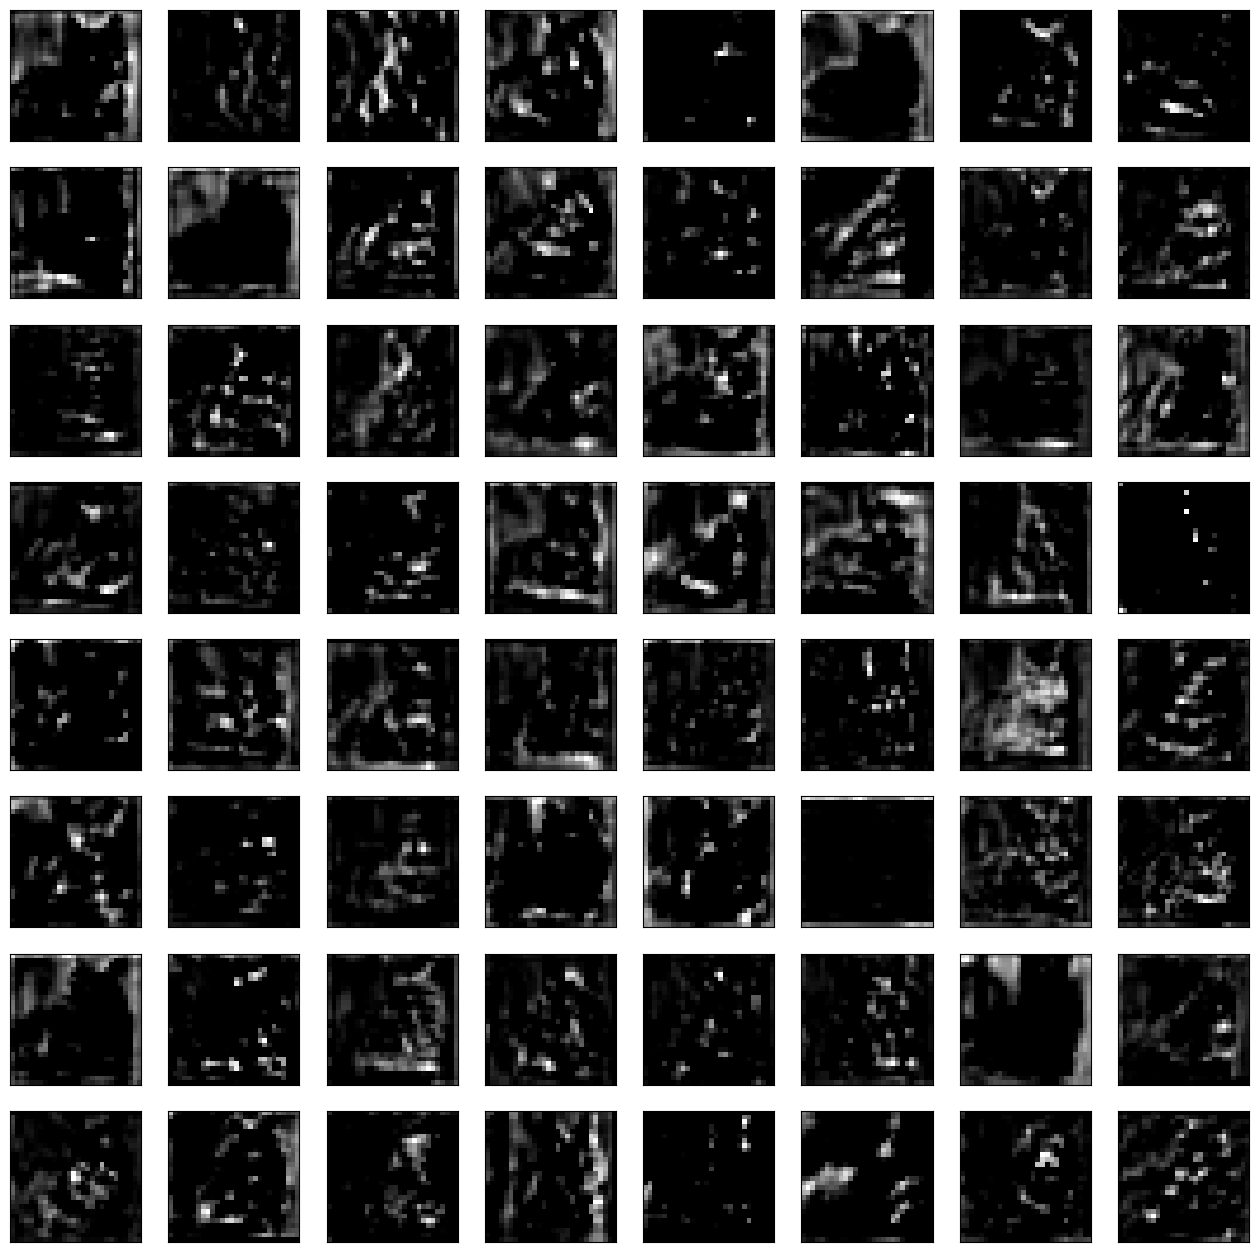

In [33]:
# get feature maps for last convolutional layer in each block
ixs = [2, 5, 11]
outputs = [vgg16_model.layers[i].output for i in ixs]
model = tf.keras.Model(inputs=[vgg16_model.input], outputs=outputs)
feature_maps = model.predict(content_image)

# plot the output from each block
square = 8
for i, fmap in enumerate(feature_maps):
    # plot all 64 maps in an 8x8 squares
    ix = 1
    print(outputs[i])
    plt.figure(figsize=(16,16))
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
            
    # show the figure
    pyplot.show()

**References**:
- [1] VGG16 Paper: https://arxiv.org/pdf/1409.1556.pdf
- [2] ImageNet : http://www.image-net.org/